In [53]:
import numpy as np
import pyodbc
import pandas as pd
from itertools import combinations
from apriori_python.apriori_algo import *
from apriori_python.utils import *
import ast

In [54]:
# # may need to change the input format depends on the ETL
# df = pd.read_csv('output_csv/table1.csv')
# # res = df['Item'].tolist()
# itemSetList = []
# # |D| = 31465
# for value in df['Item']:
#     val = ast.literal_eval(value)
#     itemSetList.append(val)

In [55]:
# test on data of the paper
dfs = pd.read_excel('data/table3.xlsx')

res = dfs['Item'].tolist()
# print(res)
itemSetList = []
for value in dfs['Item']:
    # Remove brackets from the string
    value = value.strip('[]')

    # Split the string by commas (or any other delimiter)
    list_from_string = value.split(',')

    # Convert each element to integers (if needed)
    list_from_string = [item for item in list_from_string]
    itemSetList.append(list_from_string)
print(itemSetList)

[['A', 'B', 'C', 'E'], ['B', 'E'], ['C'], ['A', 'B'], ['D'], ['A', 'B', 'D', 'E'], ['A', 'C', 'D'], ['B', 'C', 'D', 'E'], ['C', 'E'], ['E'], ['A', 'B', 'C', 'D'], ['A', 'B', 'C'], ['A', 'D'], ['A', 'C'], ['A', 'B', 'D'], ['C', 'D', 'E'], ['C', 'D'], ['A', 'D', 'E'], ['B', 'C', 'E'], ['A', 'E'], ['B', 'D', 'E'], ['A'], ['B'], ['A', 'B', 'E'], ['B', 'C', 'D'], ['A', 'C', 'E'], ['A', 'C', 'D', 'E'], ['B', 'D'], ['B', 'C'], ['D', 'E']]


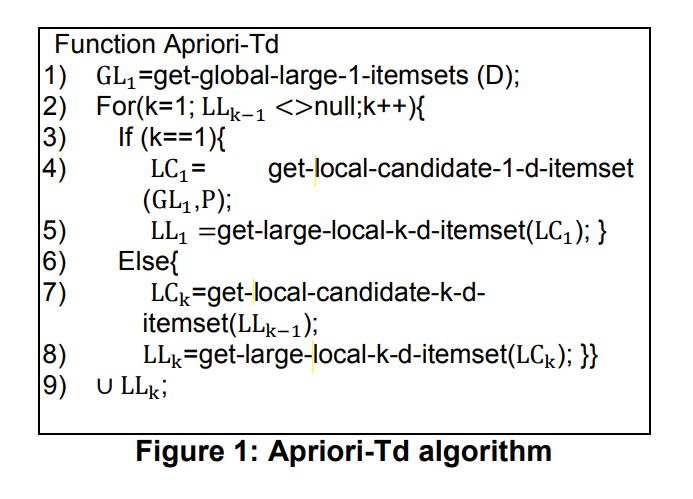

## Step 1: get global large 1 itemsets

In [56]:
# itemSetList = [['eggs', 'bacon', 'soup'],
#                 ['eggs', 'bacon', 'apple'],
#                 ['soup', 'bacon', 'banana']]
# minSup = 0.01
global_sup = 0.4  # sigma_g
local_sup = 0.1   # sigma_l 
temporal_sup = 3  # sigma_t 3 days
conf_thres = 0.5  # sigma_c 
sf = 1.3
gf = 0.7

# freqItemSet, rules = apriori(itemSetList_0, minSup=0.01, minConf=0.5)

# get all the unique items in the itemSetList
C1ItemSet = getItemSetFromList(itemSetList)
# print(C1ItemSet)

globalItemSetWithSup = defaultdict(int)

GL1 = getAboveMinSup(C1ItemSet, itemSetList, global_sup, globalItemSetWithSup)
print(GL1)


{frozenset({'D'}): 0.5, frozenset({'A'}): 0.5, frozenset({'C'}): 0.5, frozenset({'B'}): 0.5, frozenset({'E'}): 0.5}


## Step 2: Generate LC1 from GL1
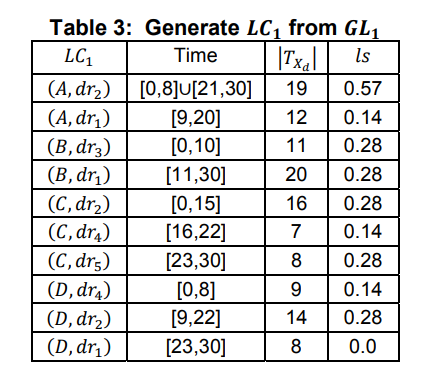

In [57]:
# read the second table
df2 = pd.read_excel('data/table2.xlsx')

res1 = dfs.values.tolist()
res2 = df2.values.tolist()
# print(res2)

# convert the GL1 elements from frozen set to list
sets = [list(s) for s in GL1]
sets.sort()
data = []

LC1 = ('X', 'Y')
Time = [0,0]
Tx = 0
ls = 0
count = 0
for x in sets:
    for y in res2:
        if set(x).issubset(set(y)):
            LC1 = (y[0],y[1])
            Time = (y[2],y[3])
            Tx = y[3] - y[2] + 1

            for z in res1:
                if set(x).issubset(set(z[1])) and z[2] >= Time[0] and z[2] <= Time[1]:
                    # print(count, z[2], Time[0], Time[1])
                    count += 1
            
            # Create a dictionary of values
            values = {'LC1': LC1, 'Time': Time, 'Tx': Tx, 'ls': float(count / len(res1))}
                    
            # Append the values to the DataFrame
            data.append(values)
            count = 0
    
            
df3 = pd.DataFrame(data)


def tolist(series):
    return series.tolist()


df4 = df3.groupby('LC1').agg({'Time': tolist, 'Tx': 'sum', 'ls': 'sum'}).reset_index()

print(df4)


         LC1                Time  Tx        ls
0   (A, dr1)           [(9, 20)]  12  0.233333
1   (A, dr2)  [(0, 8), (21, 30)]  19  0.266667
2   (B, dr1)          [(11, 30)]  20  0.333333
3   (B, dr3)           [(0, 10)]  11  0.166667
4   (C, dr2)           [(0, 15)]  16  0.266667
5   (C, dr4)          [(16, 22)]   7  0.100000
6   (C, dr5)          [(23, 30)]   8  0.133333
7   (D, dr1)          [(23, 30)]   8  0.133333
8   (D, dr2)           [(9, 22)]  14  0.233333
9   (D, dr4)            [(0, 8)]   9  0.133333
10  (E, dr1)            [(0, 9)]  10  0.166667
11  (E, dr2)          [(21, 30)]  10  0.166667
12  (E, dr3)          [(10, 20)]  11  0.166667


## Step 3 : Generate LL1 from LC1

In [58]:
data = []
for index, row in df4.iterrows():
    if row['ls'] >= local_sup:
        count = 0
        count2 = 0
        support = GL1[frozenset(row['LC1'][0])]
        for i in res1:
            timeStamp = i[2]
            for j in row['Time']:
                if timeStamp >= j[0] and timeStamp <= j[1]:
                    count += 1
                    if set(row['LC1'][0]).issubset(set(i[1])):
                        count2 += 1
        ef = round(count2 / count / support, 2)

        if ef < sf and ef > gf:
            effect = 0
        elif ef >= sf:
            effect = 1
        else:
            effect = -1

        values = {'LL1': [row['LC1']], 'Time': row['Time'], 'rs': float(count2 / count), 's': support, 'EF': ef, 'Effect': effect}        
        data.append(values)

df5 = pd.DataFrame(data)
print(df5)


           LL1                Time        rs    s    EF  Effect
0   [(A, dr1)]           [(9, 20)]  0.583333  0.5  1.17       0
1   [(A, dr2)]  [(0, 8), (21, 30)]  0.444444  0.5  0.89       0
2   [(B, dr1)]          [(11, 30)]  0.500000  0.5  1.00       0
3   [(B, dr3)]           [(0, 10)]  0.500000  0.5  1.00       0
4   [(C, dr2)]           [(0, 15)]  0.533333  0.5  1.07       0
5   [(C, dr4)]          [(16, 22)]  0.428571  0.5  0.86       0
6   [(C, dr5)]          [(23, 30)]  0.500000  0.5  1.00       0
7   [(D, dr1)]          [(23, 30)]  0.500000  0.5  1.00       0
8   [(D, dr2)]           [(9, 22)]  0.500000  0.5  1.00       0
9   [(D, dr4)]            [(0, 8)]  0.500000  0.5  1.00       0
10  [(E, dr1)]            [(0, 9)]  0.555556  0.5  1.11       0
11  [(E, dr2)]          [(21, 30)]  0.500000  0.5  1.00       0
12  [(E, dr3)]          [(10, 20)]  0.454545  0.5  0.91       0


## Step 4 : Generate large 2d itemset

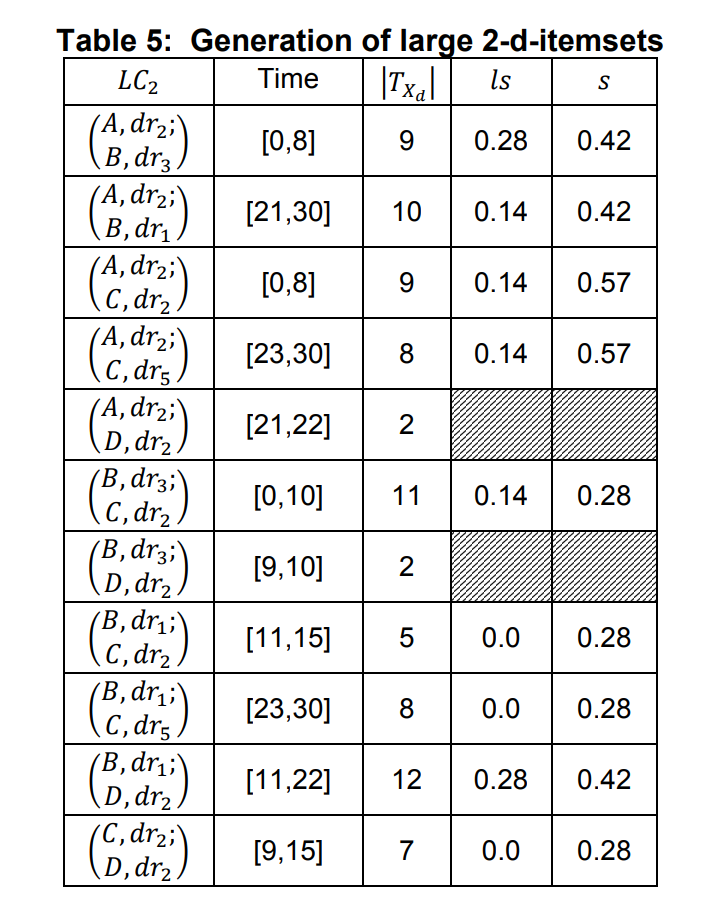

In [59]:
def inter(list1, list2):
    result = []
    for tuple1 in list1:
        for tuple2 in list2:
            if tuple1[1] > tuple2[0] and tuple1[0] < tuple2[1]:
                intersection = (max(tuple1[0], tuple2[0]), min(tuple1[1], tuple2[1]))
                result.append(intersection)
    return result

def join_lists(list1, list2):
    # Convert lists to sets to remove duplicates
    set1 = set(list1)
    set2 = set(list2)
    
    # Perform union operation to combine sets
    result_set = set1.union(set2)
    
    # Convert the resulting set back to a list
    result_list = list(result_set)
    
    return result_list

def k_minus_one_subsets(input_list, k):
    if k == 1:
        return [[x] for x in input_list]
    else:
        return [list(subset) for subset in combinations(input_list, k-1)]

def get_local_candidate_k_d_itemset(LLk, k):
    # input: LLk  a list (item properties: ['LCk', 'Time', 'Txd', 'ls', 's'])
    # output: LCk  a list
    data = []
    for i in range(len(LLk)):
        for j in range(i+1, len(LLk)):
            rec1 = LLk[i]
            rec2 = LLk[j]

            x1 = rec1['LL' + str(k-1)]
            x2 = rec2['LL' + str(k-1)]

            x1d = [i[0] for i in x1 if len(i) > 1]
            x2d = [i[0] for i in x2 if len(i) > 1]

            if sorted(x1d) == sorted(x2d):
                continue
            
            common = set(x1d).intersection(set(x2d))
            if len(common) != k-2:
                continue
            
            result = inter(rec1['Time'], rec2['Time'])
            # if there is no intersection, skip
            if len(result) == 0:
                continue
            txd = 0
            for time in result:
                txd += time[1] - time[0] + 1

            xd = sorted(join_lists(x1d, x2d))

            # subSet = k_minus_one_subsets(xd, k)

            # for subset in subSet:
            #     if not(set(subset).issubset(xd)):
            #         continue

            lck = sorted(join_lists(rec1['LL' + str(k-1)], rec2['LL' + str(k-1)]))

            subSet = k_minus_one_subsets(lck, k)

            count_k = 0
            for subset in subSet:
                for item in LLk:
                    if set(subset) == set(item['LL' + str(k-1)]):
                        count_k += 1
                        break
            if count_k != len(subSet):
                continue
            
            if txd < temporal_sup:
                s = -1
                ls = -1
            else:
                count = 0
                count2 = 0
                for item in res1:
                    for hehe in result:
                        if set(xd).issubset(set(item[1])) and ( item[2] >= hehe[0] and item[2] <= hehe[1]):
                            count2 += 1
                    if set(xd).issubset(set(item[1])):
                        count += 1
                s = float(count / len(res1))
                ls = float(count2 / len(res1))
            


            value = {'LC' + str(k): lck, 'Time': result, 'Txd': txd, 'ls': ls, 's': s}
            
            data.append(value)
    return data


In [60]:
# data = []
# res = df5.values.tolist()
# # for index_df5, row_df5 in df5.iterrows():
# #     for index, row in df5[]
# for i in range(len(res)):
#     for j in range(i+1, len(res)):
#         rec1 = res[i]
#         rec2 = res[j]
#         result = inter(rec1[1], rec2[1])
#         # if there is no intersection, skip
#         if len(result) == 0:
#             continue
#         txd = 0
#         for time in result:
#             txd += time[1] - time[0] + 1
            
#         lc2 = []
#         lc2.append(rec1[0])
#         lc2.append(rec2[0])


#         tempSet = [i[0] for i in lc2]
#         tempSet = set(tempSet)

#         if txd < temporal_sup:
#             s = -1
#             ls = -1
#         else:
#             count = 0
#             count2 = 0
#             count3 = 0
#             for item in res1:
#                 for hehe in result:
#                     if tempSet.issubset(set(item[1])) and ( item[2] >= hehe[0] and item[2] <= hehe[1]):
#                         count2 += 1
#                 if tempSet.issubset(set(item[1])):
#                     count += 1
#             s = float(count / len(res1))
#             ls = float(count2 / len(res1))
        


#         value = {'LC2': lc2, 'Time': result, 'Txd': txd, 'ls': ls, 's': s}

#         data.append(value)
data = get_local_candidate_k_d_itemset(data, 2)
df6 = pd.DataFrame(data)

print(df6)


    

TypeError: unhashable type: 'dict'

In [ ]:
def get_large_local_k_d_itemset(LCk, k):
    # input: LCk  a list (item properties: ['LCk', 'Time', 'Txd', 'ls', 's'])
    # output: LLk  a list
    data = []
    for item in LCk:
        if item['Txd'] > temporal_sup:
            if item['ls'] >= local_sup:
                LLk = item['LC'+ str(k)]
                time = item['Time']
                count = 0
                count2 = 0
                support = item['s']
                for i in res1:
                    timeStamp = i[2]
                    for j in item['Time']:
                        if timeStamp >= j[0] and timeStamp <= j[1]:
                            count += 1
                            tempSet = [i[0] for i in item['LC'+ str(k)]]

                            if set(tempSet).issubset(set(i[1])):
                                count2 += 1
                ef = round(count2 / count / support, 2)

                if ef < sf and ef > gf:
                    effect = 0
                elif ef >= sf:
                    effect = 1
                else:
                    effect = -1
                value = {'LL' + str(k): LLk, 'Time': time, 'rs': float(count2 / count), 's': support, 'EF': ef, 'Effect': effect}
                
                data.append(value)
        else:
            continue
    return data

In [ ]:
# data = []
# for index, row in df6.iterrows():
#     if row['ls'] >= local_sup:
#         count = 0
#         count2 = 0
#         support = row['s']
#         for i in res1:
#             timeStamp = i[2]
#             for j in row['Time']:
#                 if timeStamp >= j[0] and timeStamp <= j[1]:
#                     count += 1
#                     tempSet = [i[0] for i in row['LC2']]
#                     if set(tempSet).issubset(set(i[1])):
#                         count2 += 1
#         ef = round(count2 / count / support, 2)

#         if ef < sf and ef > gf:
#             effect = 0
#         elif ef >= sf:
#             effect = 1
#         else:
#             effect = -1

#         values = {'LL2': row['LC2'], 'Time': row['Time'], 'rs': float(count2 / count), 's': support, 'EF': ef, 'Effect': effect}        
#         data.append(values)
# print(data)
# df7 = pd.DataFrame(data)
# # print(df7)
# print(data)
data = get_large_local_k_d_itemset(data, 2)
df7 = pd.DataFrame(data)
print(df7)

                    LL2        Time        rs         s    EF  Effect
0  [(A, dr1), (B, dr1)]  [(11, 20)]  0.300000  0.233333  1.29       0
1  [(A, dr1), (C, dr2)]   [(9, 15)]  0.428571  0.233333  1.84       1
2  [(A, dr1), (D, dr2)]   [(9, 20)]  0.333333  0.233333  1.43       1
3  [(A, dr2), (B, dr3)]    [(0, 8)]  0.375000  0.233333  1.61       1
4  [(A, dr2), (E, dr2)]  [(21, 30)]  0.300000  0.233333  1.29       0
5  [(B, dr1), (D, dr2)]  [(11, 22)]  0.250000  0.233333  1.07       0
6  [(B, dr3), (E, dr1)]    [(0, 9)]  0.444444  0.233333  1.90       1
7  [(C, dr2), (E, dr1)]    [(0, 9)]  0.333333  0.233333  1.43       1


In [ ]:
data = get_local_candidate_k_d_itemset(data, 3)
df8 = pd.DataFrame(data)
print(df8)

                              LC3        Time  Txd        ls    s
0  [(A, dr1), (B, dr1), (D, dr2)]  [(11, 20)]   10  0.066667  0.1
1  [(A, dr1), (B, dr1), (D, dr2)]  [(11, 20)]   10  0.066667  0.1
2  [(A, dr1), (B, dr1), (D, dr2)]  [(11, 20)]   10  0.066667  0.1
